In [1]:
! pip install swifter numpy pandas datasketch scikit-learn matplotlib

### Imports

The THRESHOLD defines the minimal percentage of similarity that two documents are assumed duplicate/similar.

In [2]:
import time
import swifter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from datasketch import MinHashLSH, MinHash

THRESHOLD = 0.8

## Read data and preprocessing

Preprocessing is a bit crucial in this task beacause the datasets contain text with Chinise, Arab etc. characters.
The below algorithms are tested and working for English characters only.

In [3]:
train_df = pd.read_csv('../assist_material/datasets/extracted/q2a/corpusTrain.csv', sep=',')
train_df.columns = ['id', 'content']

test_df = pd.read_csv('../assist_material/datasets/extracted/q2a/corpusTest.csv', sep=',')
test_df.columns = ['id', 'content']


def preprocess(df):
    """
    Cleans up a given dataframe
    :param df: The dataframe to clean
    :return: The cleaned dataframe
    """

    _df = df.copy(deep=True)
    _df['content'] = _df['content'].str.lower()
    _df['content'] = _df['content'].swifter.apply(lambda row: row.encode('ascii',errors='ignore').decode())
    _df = _df[_df['content'].str.split().str.len().gt(2)]
    _df['content'] = _df['content'].str.replace(r'[\n\'\"?\.,:\(\)]', '', regex=True)
    _df.reset_index(drop=True, inplace=True)
    return _df


train_df = preprocess(train_df)
test_df = preprocess(test_df)

# Vectorize texts
vectorizer = TfidfVectorizer()
train_tfidf = vectorizer.fit_transform(train_df['content'])

Pandas Apply:   0%|          | 0/531990 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5374 [00:00<?, ?it/s]

## Exact Cosine Similarity

The block below calculates the Cosine Similarity between the documents of the datasets.
Pretty straightforward.

In [4]:
cosine_query_start_time = time.time()
cosine_duplicates = 0


for query in test_df.itertuples(index=False):
    query_tfidf = vectorizer.transform([query.content])

    similarities = cosine_similarity(query_tfidf, train_tfidf).flatten()
    if np.any(similarities > THRESHOLD):
        cosine_duplicates += 1

    # UNCOMMENT THE BELOW TO PRINT THE DUPLICATES
    # indexes = np.where(similarities > THRESHOLD)
    # print(f"Query: {query}")
    # for index in indexes:
    #     print(train_df['content'][index])

cosine_query_end_time = time.time()
print(f'Total duplicates found: {cosine_duplicates}')
print(f'Cosine Similarity query time {(cosine_query_end_time - cosine_query_start_time):.2f} seconds')

Total duplicates found: 1351
Cosine Similarity query time 669.89 seconds


## Exact Jaccard Similarity

The block below calculates the Jaccard Similarity pairwise for all documents of the two sets. 
The Jaccard Similarity algorithm is custom and based on the known math formula. Also in order
to boost a bit the execution time, I used the library 'swifter' which parallelize dataframe
'apply' function invocation. Still, it is very slow in comparison with the other solutions
in this notebook.

In [5]:
def jaccard_similarity(query, document):
    """
    This method estimates the Jaccard similarity between two documents

    :param query: The first document
    :param document: The second document
    :return: The similarity between the two documents
    """   
    # List the unique words in a document
    words_doc1 = set(query.lower().split()) 
    words_doc2 = set(document.lower().split())
    
    # Find the intersection of words list of doc1 & doc2
    intersection = words_doc1.intersection(words_doc2)

    # Find the union of words list of doc1 & doc2
    union = words_doc1.union(words_doc2)
        
    # Calculate Jaccard similarity score 
    # using length of intersection set divided by length of union set
    return float(len(intersection)) / len(union)


jaccard_query_start_time = time.time()
jaccard_duplicates = 0

for query in test_df.itertuples(index=False):
    similarities = train_df['content'].swifter.progress_bar(False).apply(
        lambda row: jaccard_similarity(row, query.content))
    if np.any(similarities > THRESHOLD):
        jaccard_duplicates += 1

    # UNCOMMENT THE BELOW TO PRINT THE DUPLICATES
    # indexes = np.where(similarities > THRESHOLD)
    # print(f'Query: {query}')
    # for index in indexes:
    #     print(train_df['content'][index])


jaccard_query_end_time = time.time()
print(f'Total duplicates found: {jaccard_duplicates}')
print(f'Jaccard Similarity query time {(jaccard_query_end_time - jaccard_query_start_time):.2f} seconds')

Total duplicates found: 430
Jaccard Similarity query time 13329.98 seconds


## Random Projection LSH with Cosine Similarity
The below block of code contains a custom implementation of Random Projection LSH with Cosine Similarity as metric. The
implementation of this algorithm was based on the available documentation, theory and some
medium/stackexchange/stackoverflow articles. The model is trained for k (from 1 to 10) hyperplanes (random generated
vectors via Guassian distribution). Briefly, each bin contains bit vectors of documents that were created using 
the TFIDF vector applying the 'dot' formula. In that way we can associate each query bit vector with the trained 
bit vectors. The bin that has the same bit vector with the query's then that bin contains the approximate nearest 
neighbors of this query. Finally, the cosine similarities of these documents are calculated and the these that have 
a score greater than the defined threshold are asumed as similar.

In [6]:
def random_vectors_generator(dimension, n_vectors):
    """
    Generates a collection of random vectors from the standard Gaussian distribution.
    :param dimension: The dimension of the vector
    :param n_vectors: The number of vectors
    :return: Array with random vectors
    """
    return np.random.randn(dimension, n_vectors)


def train_lsh(X_tfidf, n_vectors):
    """
    Method that creates a LSH model given the TFIDF vector to train
    :param X_tfidf: The TFIDF vector to train the model
    :param n_vectors: The number of random vectors to generate
    :return: The model
    """
    np.random.seed(0)
    dim = X_tfidf.shape[1]
    random_vectors = random_vectors_generator(dim, n_vectors)

    # Partition data points into bins and encode bin index bits into integers
    bin_indices_bits = X_tfidf.dot(random_vectors) >= 0
    # Compute the dot product between the document vector and the vector consisting of powers of 2
    # x << y is the same as multiplying x by 2 ** y
    powers_of_two = 1 << np.arange(n_vectors - 1, -1, step=-1)
    # Final integer representation of individual bins
    bin_indices = bin_indices_bits.dot(powers_of_two)

    # Update `table` so that `table[i]` is the list of document ids with bin index equal to i
    table = defaultdict(list)
    for idx, bin_index in enumerate(bin_indices):
        table[bin_index].append(idx)

    model = {'table': table,
             'random_vectors': random_vectors,
             'bin_indices': bin_indices,
             'bin_indices_bits': bin_indices_bits}
    return model


def get_candidates(query_bin_bits, table, candidate_set):
    """
    For a given query vector and trained LSH model's table
    return all candidate neighbors with the specified search radius.

    Example
    -------
    model = train_lsh(X_tfidf, n_vectors=16)
    query = model['bin_index_bits'][0]  # vector for the first document
    candidates = get_candidates(query, model['table'])
    :param query_bin_bits: The binary representation of the query document
    :param table: The trained hash table
    :param candidate_set: The set that holds the candidate neighbours
    :return: The set that holds the candidate neighbours
    """
    if candidate_set is None:
        candidate_set = set()

    n_vectors = query_bin_bits.shape[0]
    powers_of_two = 1 << np.arange(n_vectors - 1, -1, step=-1)

    # Convert the new bit vector to an integer index
    nearby_bin = query_bin_bits.dot(powers_of_two)

    # fetch the list of documents belonging to
    # the bin indexed by the new bit vector,
    # then add those documents to candidate_set;
    # make sure that the bin exists in the table
    if nearby_bin in table:
        candidate_set.update(table[nearby_bin])

    return candidate_set


def get_nearest_neighbors(X_tfidf, query_vector, model):
    """
    Business method that returns the approximate nearest neighbors of a given document. Here it is calculated the bit
    index of the document to search and using the methods above we extract the neighbors along with the cosine
    similarity with descending order.
    :param X_tfidf: The train TFIDF
    :param query_vector: The document to search TFIDF
    :param model: The LSH model
    :return: List with nearest neighbours with cosine similarities
    """
    table = model['table']
    random_vectors = model['random_vectors']

    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = np.ravel(query_vector.dot(random_vectors) >= 0)

    # Search nearby bins and collect candidates
    candidate_set = set()
    candidate_set = get_candidates(bin_index_bits, table, candidate_set)

    # Sort candidates by their true distances from the query
    candidate_list = list(candidate_set)
    candidates = X_tfidf[candidate_list]
    similarities = cosine_similarity(candidates, query_vector).flatten()

    similarities_col = 'similarities'
    nearest_neighbors = pd.DataFrame({
        'id': candidate_list, similarities_col: similarities
    }).sort_values(similarities_col, ascending=False).reset_index(drop=True)
    return nearest_neighbors


lsh_projection_build_times = []
lsh_projection_query_times = []
lsh_projection_duplicates = []
for k in range(1, 10 + 1):
    lsh_projection_build_start_time = time.time()
    lsh_model = train_lsh(train_tfidf, k)
    lsh_projection_build_end_time = time.time()

    print(f'LSH Projection with Cosine Similarity build time '
          f'{(lsh_projection_build_end_time - lsh_projection_build_start_time):.2f} seconds for k = {k}')
    lsh_projection_build_times.append(lsh_projection_build_end_time - lsh_projection_build_start_time)

    lsh_projection_query_start_time = time.time()
    duplicates = 0
    for query in test_df.itertuples(index=False):
        query_tfidf = vectorizer.transform([query.content])
        nearest_neighbors = get_nearest_neighbors(train_tfidf, query_tfidf, lsh_model)
        # If the max value is above 0.8 consider it duplicate
        if nearest_neighbors['similarities'][0] > THRESHOLD:
            duplicates += 1

        # UNCOMMENT THE BELOW TO PRINT THE DUPLICATES
        # indexes = nearest_neighbors[nearest_neighbors['similarities'] > THRESHOLD]
        # print(f'Query: {query}')
        # for index in indexes.itertuples(index=False):
        #      print(train_df['content'][index.id])

    lsh_projection_query_end_time = time.time()
    lsh_projection_duplicates.append(duplicates)
    lsh_projection_query_times.append(lsh_projection_query_end_time - lsh_projection_query_start_time)
    print(f'Total duplicates found: {duplicates} for k = {k}')
    print(f'LSH Projection with Cosine Similarity query time '
          f'{(lsh_projection_query_end_time - lsh_projection_query_start_time):.2f} seconds')

LSH Projection with Cosine Similarity build time 0.17 seconds for k = 1
Total duplicates found: 1213 for k = 1
LSH Projection with Cosine Similarity query time 1152.66 seconds
LSH Projection with Cosine Similarity build time 0.20 seconds for k = 2
Total duplicates found: 1098 for k = 2
LSH Projection with Cosine Similarity query time 611.88 seconds
LSH Projection with Cosine Similarity build time 0.19 seconds for k = 3
Total duplicates found: 942 for k = 3
LSH Projection with Cosine Similarity query time 409.84 seconds
LSH Projection with Cosine Similarity build time 0.23 seconds for k = 4
Total duplicates found: 842 for k = 4
LSH Projection with Cosine Similarity query time 206.18 seconds
LSH Projection with Cosine Similarity build time 0.23 seconds for k = 5
Total duplicates found: 756 for k = 5
LSH Projection with Cosine Similarity query time 99.04 seconds
LSH Projection with Cosine Similarity build time 0.27 seconds for k = 6
Total duplicates found: 692 for k = 6
LSH Projection wit

## Min-Hash LSH with Jaccard Similarity

The below block of code estimates duplicates using MinHash LSH with Jaccard Similarity as metric. In order to implement
this type of deduplication I used the library 'datasketch'. The model is trained and tested for 3 different values 
(16, 32, 64) of the hyper-parameter 'permutation'. In order to calculate MinHash, initially a dictionary from all the 
words of the questions must be created. Then applying a number of random permutations using these words we create 
fingerprints of each document of the train set. The more permutations we do, the closer the approximations will be.

In [10]:
def train_min_lsh(X, n_permutations):
    """
    Method that creates a Min-LSH model given the training dataframe
    :param X: The train dataframe
    :param n_permutations: The number of permutations to apply
    :return: The model
    """
    model = MinHashLSH(threshold=THRESHOLD, num_perm=n_permutations)
    for entry in X.itertuples(index=False):
        min_hash = MinHash(num_perm=n_permutations)
        set_text = set(entry.content.split())
        for d in set_text:
            min_hash.update(d.encode('utf8'))

        model.insert(entry.id, min_hash)

    return model

min_hash_lsh_build_times = []
min_hash_lsh_query_times = []
min_hash_lsh_duplicates = []
for perm in [16, 32, 64]:
    
    min_hash_lsh_build_start_time = time.time()
    lsh_model = train_min_lsh(train_df, perm)
    min_hash_lsh_build_end_time = time.time()

    print(f'Min-Hash LSH with Jaccard Similarity build time '
          f'{(min_hash_lsh_build_end_time - min_hash_lsh_build_start_time):.2f} seconds for perm = {perm}')
    min_hash_lsh_build_times.append(min_hash_lsh_build_end_time - min_hash_lsh_build_start_time)
    
    min_hash_lsh_query_start_time = time.time()
    duplicates = 0
    for query in test_df.itertuples(index=False):
        min_hash = MinHash(num_perm=perm)
        set_text = set(query.content.split())
        for d in set_text:
            min_hash.update(d.encode('utf8'))
        similarities = lsh_model.query(min_hash)
        
        if similarities:
            duplicates += 1
    
        # UNCOMMENT THE BELOW TO PRINT THE DUPLICATES
        # print('Query', query)
        # for index in result:
        #     print(train_df.loc[train_df['id'] == index])

    min_hash_lsh_query_end_time = time.time()
    min_hash_lsh_duplicates.append(duplicates)
    min_hash_lsh_query_times.append(min_hash_lsh_query_end_time - min_hash_lsh_query_start_time)
    print(f'Total duplicates found: {duplicates} for perm = {perm}')
    print(f'Min-Hash LSH with Jaccard Similarity query time '
          f'{(min_hash_lsh_query_end_time - min_hash_lsh_query_start_time):.2f} seconds')


Min-Hash LSH with Jaccard Similarity build time 343.65 seconds for perm = 16
Total duplicates found: 816 for perm = 16
Min-Hash LSH with Jaccard Similarity query time 3.40 seconds
Min-Hash LSH with Jaccard Similarity build time 447.69 seconds for perm = 32
Total duplicates found: 619 for perm = 32
Min-Hash LSH with Jaccard Similarity query time 4.64 seconds
Min-Hash LSH with Jaccard Similarity build time 665.09 seconds for perm = 64
Total duplicates found: 673 for perm = 64
Min-Hash LSH with Jaccard Similarity query time 6.53 seconds


### Generating stats table

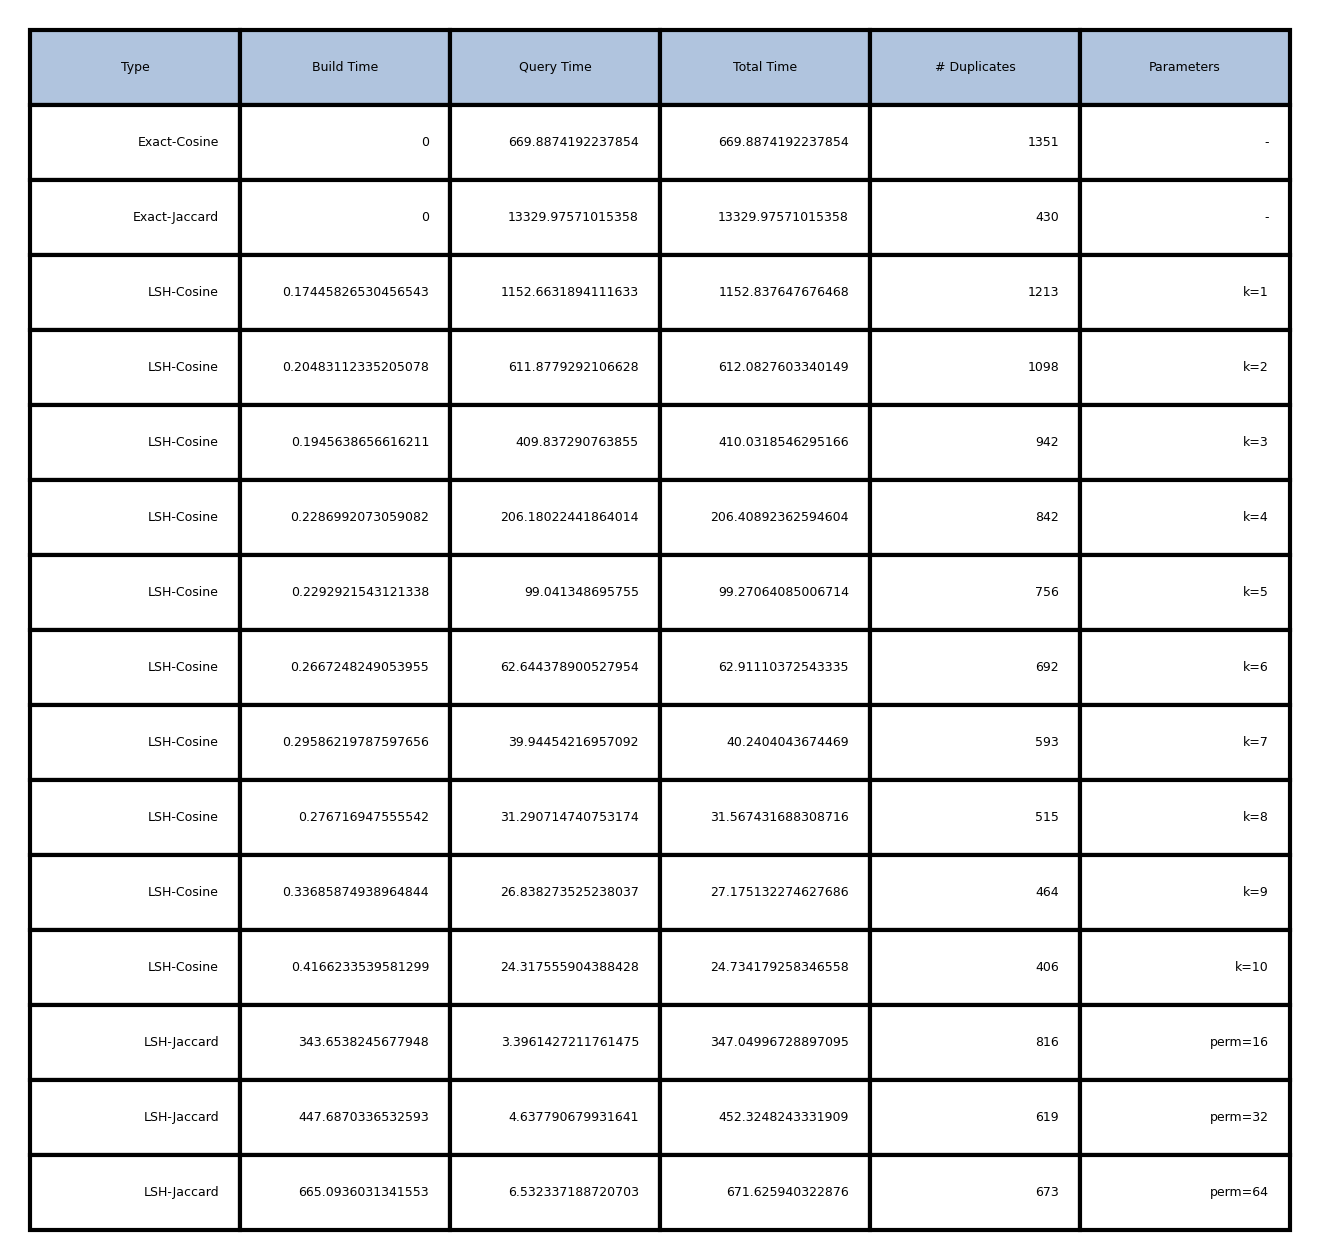

In [11]:
data_table = [['Exact-Cosine',
               '0',
               f'{cosine_query_end_time - cosine_query_start_time}',
               f'{cosine_query_end_time - cosine_query_start_time}',
               f'{cosine_duplicates}',
               '-'
               ],
              ['Exact-Jaccard',
               '0',
               f'{jaccard_query_end_time - jaccard_query_start_time}',
               f'{jaccard_query_end_time - jaccard_query_start_time}',
               f'{jaccard_duplicates}',
               '-'
              ]]

for i in range(1, 10 + 1):
    data_table.append(['LSH-Cosine',
                       f'{lsh_projection_build_times[i-1]}',
                       f'{lsh_projection_query_times[i-1]}',
                       f'{lsh_projection_build_times[i-1] + lsh_projection_query_times[i-1]}',
                       f'{lsh_projection_duplicates[i-1]}',
                       f'k={i}'])

for it, val in enumerate([16, 32, 64]):
    data_table.append(['LSH-Jaccard',
                       f'{min_hash_lsh_build_times[it]}',
                       f'{min_hash_lsh_query_times[it]}',
                       f'{min_hash_lsh_build_times[it] + min_hash_lsh_query_times[it]}',
                       f'{min_hash_lsh_duplicates[it]}',
                       f'perm={val}'])

plt.figure(dpi=300)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(left=0.2, bottom=0.2)

the_table = plt.table(cellText=data_table,
                      colLabels=['Type', 'Build Time', 'Query Time', 'Total Time', '# Duplicates', 'Parameters'],
                      colColours=['lightsteelblue'] * 6,
                      loc='center')
the_table.scale(1, 1.5)
fig = plt.gcf()
plt.show()